In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from re import search
import datetime as date
import datetime
import copy
from matplotlib.colors import ListedColormap

In [2]:
# read in data
df_temp = pd.read_csv('./data/Temperature Data.csv')
df_pop = pd.read_csv('./data/Population Data.csv')

Preview some things about the data

In [3]:
# preview temp
print(df_temp.shape)
df_temp.head()

(89219, 9)


name  country_name country_code      continent station_code  \
0        Atlanta  UnitedStates          USA  North America         KATL   
1  Windsor Locks  UnitedStates          USA  North America         KBDL   
2      Nashville  UnitedStates          USA  North America         KBNA   
3          Boise  UnitedStates          USA  North America         KBOI   
4         Boston  UnitedStates          USA  North America         KBOS   

  location_date  temp_mean_c  temp_min_c  temp_max_c  
0     4/20/2021    17.491667        12.2        23.3  
1     4/20/2021    13.887500         3.9        22.2  
2     4/20/2021    15.175000         6.7        23.3  
3     4/20/2021     9.329167         1.7        15.6  
4     4/20/2021    16.716667        10.0        23.9

In [4]:
# preview pop
print(df_pop.shape)
df_pop.head()

(285, 5)


City          State  population       Lon      Lat
0   Henderson         Nevada      260068 -115.0375  36.0122
1  Manchester  New Hampshire      109830  -71.4439  42.9847
2   Elizabeth     New Jersey      125660  -74.1935  40.6663
3      Newark     New Jersey      277540  -74.1726  40.7242
4    Paterson     New Jersey      146427  -74.1628  40.9147

Going to make everything lower case to make the data pre process easier

In [5]:
df_pop['City'] = df_pop['City'].str.lower()
df_temp['name'] = df_temp['name'].str.lower()

In [6]:
print('Cities in temp dataset %d.' % df_temp['name'].nunique())

Cities in temp dataset 38.


In [7]:
print('Cities in pop dataset %d.' % df_pop['City'].nunique())

Cities in pop dataset 274.


In [8]:
# find how many cities we have temps that we also have population data for
cities_temp = list(df_temp.name.unique())
print('Cities in temp dataset in pop dataset %d.' % pd.DataFrame(df_pop['City'].unique()).isin(cities_temp).sum()[0])

Cities in temp dataset in pop dataset 27.


Appears only 27 of the cities we have temp for appear in the pop dataset.

In [9]:
list(set(cities_temp) - set(df_pop['City'].unique()))

['windsor locks',
 'covington',
 "chicago o'hare",
 'albany',
 'wash dc/dulles',
 'detroit/wayne',
 'phoenix/sky hrbr',
 'st louis/lambert',
 'nyc/laguardia',
 'sacramento/execu',
 'raleigh/durham']

Manually going to see if we have any of these cities in our pop dataset.

In [10]:
# leverage python regex to find matches
for city in df_pop['City'].unique():
    # sacramento exist?
    if search('sac', city):
        print(city)
    # will come back to albany
    # how about dc
    elif search('dc', city):
        print(city)
    # no luck
    # st louis?
    elif search('louis', city):
        # dont need louis ville
        if search('st', city):
            print(city)
    # new york?
    elif search('york', city):
            print(city)
    # chi
    elif search('chica', city):
        print(city)
    # detroit
    elif search('detro', city):
        print(city)
    # raleigh
    elif search('raleigh', city):
        print(city)
    # windsor?
    elif search('dsor', city):
        print(city)
    # chris paul
    elif search('phoe', city):
        print(city)
    elif search('coving', city):
        print(city)  

new york
raleigh
chicago
detroit
st. louis
phoenix
sacramento


With very little time we were able to recover 7 of the missing 11 cities in the population data to be leveraged with our temp data. Next, it would be best to do some deep diving into each city name then if we still have no luck some digging on the web could be done to include the population for every city we have temp data for. In this case to save time we will elect to throw away the temp data that exists for cities I was not able to quickly get the pop data for.

In [11]:
# numpy where is great for quickly updating values, also very read able
df_temp['name'] = np.where(df_temp['name']=='sacramento/execu', 'sacramento', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=='phoenix/sky hrbr', 'phoenix', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=='st louis/lambert', 'st. louis', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=='detroit/wayne', 'detroit', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=="chicago o'hare", 'chicago', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=='raleigh/durham', 'raleigh', df_temp['name'])
df_temp['name'] = np.where(df_temp['name']=='nyc/laguardia', 'new york', df_temp['name'])

In [12]:
# view the cities we have temp for that we dont have pop data after the clean up
list(set(df_temp['name'].unique()) - set(df_pop['City'].unique()))

['windsor locks', 'covington', 'albany', 'wash dc/dulles']

Drop these values from the temp dataset

In [13]:
df_temp = df_temp[~df_temp['name'].isin(['wash dc/dulles', 'covington', 'albany', 'windsor locks'])]

In [14]:
df_temp.shape

(80070, 9)

Lost ~9k days of data recorded around US by tossing out those cities. We proceed.

need to create proportion values for the population that we have temperature estimates for

In [15]:
# only cities we have pop data for
df_pop = df_pop[df_pop['City'].isin(df_temp['name'].unique())].reset_index(drop=True)

In [16]:
df_pop['prop'] = df_pop['population'] / df_pop['population'].sum()

Combining station data for cities for same day

In [17]:
df_temp = df_temp.groupby(['name', 'location_date']).agg({'temp_mean_c': 'mean', 'temp_min_c': 'mean', 'temp_max_c': 'mean'}).reset_index()

change location_date to date type

In [18]:
def date_converter(x):
    split_date = x.split('/')
    return datetime.datetime(int(split_date[2]), int(split_date[0]), int(split_date[1]))

In [19]:
df_temp['date'] = [date_converter(x) for x in df_temp['location_date']]

create index for each city and day between 2015-1-1 and 2021-4-20

In [20]:
pd.date_range(df_temp['date'].min(), df_temp['date'].max())

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14',
               '2021-04-15', '2021-04-16', '2021-04-17', '2021-04-18',
               '2021-04-19', '2021-04-20'],
              dtype='datetime64[ns]', length=2302, freq='D')

each city will have 2302 records

In [21]:
index = pd.MultiIndex.from_product([df_temp['name'].unique(), pd.date_range(df_temp['date'].min(), df_temp['date'].max())],names=['name', 'date'])
df_index = pd.DataFrame(index=index).reset_index()

join our temp data

In [22]:
df = df_index.merge(df_temp, how='left', right_on=['name', 'date'], left_on=['name', 'date'])

create indicator for future imputations

In [23]:
df['missing'] = np.where(df['location_date'].isnull(), 1, 0)
df['missing'].sum()

485

485 total days that will require imputation. 

In [24]:
df = df.sort_values(by=['name', 'date'])

will impute values for each city with moving average 

In [25]:
df.head()

name       date location_date  temp_mean_c  temp_min_c  temp_max_c  \
0  atlanta 2015-01-01      1/1/2015     6.758333         0.0        13.9   
1  atlanta 2015-01-02      1/2/2015     8.116667         6.7         9.4   
2  atlanta 2015-01-03      1/3/2015    11.154167         8.9        16.1   
3  atlanta 2015-01-04      1/4/2015    14.279167         6.7        17.8   
4  atlanta 2015-01-05      1/5/2015     5.045833         1.1         8.9   

   missing  
0        0  
1        0  
2        0  
3        0  
4        0

In [26]:
df_updates = df[['temp_mean_c', 'temp_min_c', 'temp_max_c']].rolling( 3,center=True,min_periods=1).mean()

In [27]:
df.update(df_updates['temp_mean_c'])
df.update(df_updates['temp_max_c'])
df.update(df_updates['temp_min_c'])

Join prop data to temp data 

In [28]:
df = df.merge(df_pop, how='left', right_on='City', left_on='name')

checking my proportion value

In [29]:
df.prop.sum()

2302.0

sum of the proportion values is the same as the expected number of days

In [30]:
df = df[['date', 'name', 'temp_mean_c','temp_min_c','temp_max_c','missing', 'prop']]

In [31]:
df.head()

date     name  temp_mean_c  temp_min_c  temp_max_c  missing      prop
0 2015-01-01  atlanta     7.437500    3.350000   11.650000        0  0.012762
1 2015-01-02  atlanta     8.676389    5.200000   13.133333        0  0.012762
2 2015-01-03  atlanta    11.183333    7.433333   14.433333        0  0.012762
3 2015-01-04  atlanta    10.159722    5.566667   14.266667        0  0.012762
4 2015-01-05  atlanta     8.266667    2.233333   12.800000        0  0.012762

In [32]:
for x in ['temp_mean_c','temp_min_c','temp_max_c']:
    df[x + '_prop'] = df[x] * df['prop']

In [33]:
df.head()

date     name  temp_mean_c  temp_min_c  temp_max_c  missing      prop  \
0 2015-01-01  atlanta     7.437500    3.350000   11.650000        0  0.012762   
1 2015-01-02  atlanta     8.676389    5.200000   13.133333        0  0.012762   
2 2015-01-03  atlanta    11.183333    7.433333   14.433333        0  0.012762   
3 2015-01-04  atlanta    10.159722    5.566667   14.266667        0  0.012762   
4 2015-01-05  atlanta     8.266667    2.233333   12.800000        0  0.012762   

   temp_mean_c_prop  temp_min_c_prop  temp_max_c_prop  
0          0.094920         0.042754         0.148681  
1          0.110731         0.066364         0.167612  
2          0.142725         0.094867         0.184203  
3          0.129662         0.071044         0.182076  
4          0.105502         0.028502         0.163358

In [34]:
df_missing_plot = copy.copy(df)

In [35]:
df = df.groupby('date').agg({'temp_mean_c': 'mean', 'temp_min_c': 'mean', 'temp_max_c': 'mean',
                        'temp_mean_c_prop': 'sum', 'temp_min_c_prop': 'sum', 'temp_max_c_prop': 'sum', 'missing': 'sum'}).reset_index()

sum of the proportion values is the same as the expected number of days

In [36]:
df['missing'].sum() 

514

This sum value is higher than my 485 because richmond and columbus are listed twice in the population dataset. The join of propportions above had to duplicate the temp data for these two cities. I should dig in and figure out based on the lat and long and listed temps which population is correct instead since the proportion is still being applied at leas 50% the impact should be small and i will proceed.

In [37]:
df['month'] = [x.month for x in df['date']]

In [38]:
df['season'] = np.where(df['month'].isin([6,7,8,]), 'summer', '0')
df['season'] = np.where(df['month'].isin([9,10,11,]), 'fall', df['season'])
df['season'] = np.where(df['month'].isin([12,1,2,]), 'winter', df['season'])
df['season'] = np.where(df['month'].isin([3,4,5,]), 'spring', df['season'])

create datasets for plots

In [39]:
df_month = df.groupby('month').mean()

In [40]:
df_season = df.groupby('season').mean()

plot

In [41]:
df_season['order'] = [3,1,2,4]

In [42]:
df_season = df_season.sort_values(by='order')

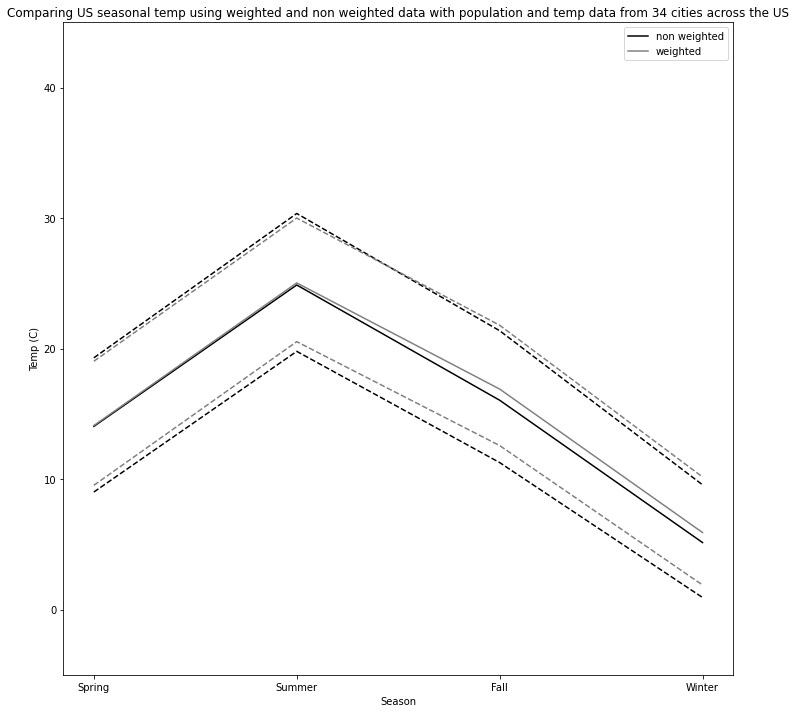

In [43]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(np.arange(0,4), df_season['temp_mean_c'], color='black', label='non weighted')
ax.plot(np.arange(0,4), df_season['temp_min_c'], color='black', linestyle='--')
ax.plot(np.arange(0,4), df_season['temp_max_c'], color='black', linestyle='--')
ax.plot(np.arange(0,4), df_season['temp_mean_c_prop'], color='grey', label='weighted')
ax.plot(np.arange(0,4), df_season['temp_min_c_prop'], color='grey', linestyle='--')
ax.plot(np.arange(0,4), df_season['temp_max_c_prop'], color='grey', linestyle='--')
ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
ax.set_xlabel('Season')
ax.set_ylabel('Temp (C)')
ax.set_title('Comparing US seasonal temp using weighted and non weighted data with population and temp data from 34 cities across the US')
ax.legend()
ax.set_ylim(-5,45)
plt.show()

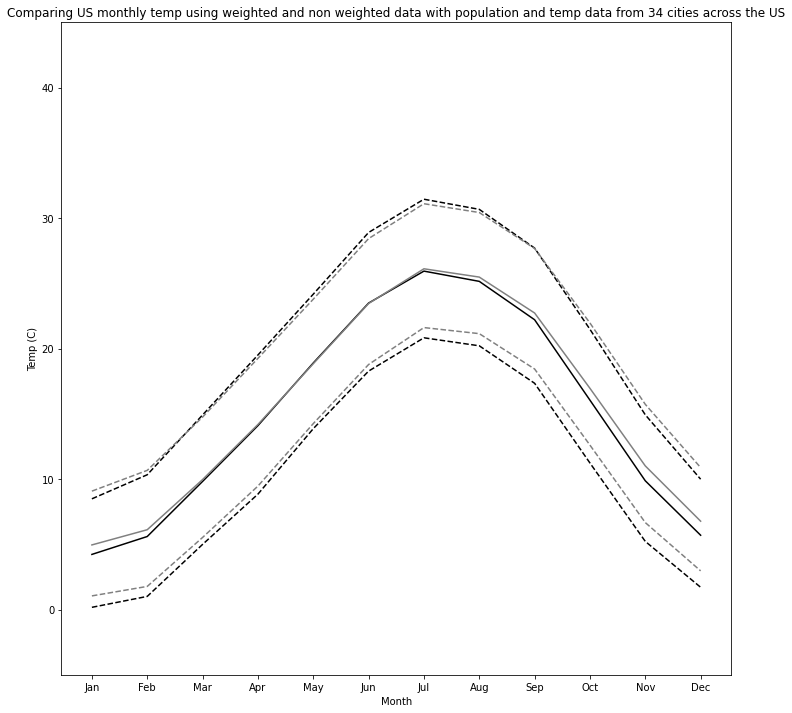

In [44]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(np.arange(1,13), df_month['temp_mean_c'], color='black')
ax.plot(np.arange(1,13), df_month['temp_min_c'], color='black', linestyle='--')
ax.plot(np.arange(1,13), df_month['temp_max_c'], color='black', linestyle='--')
ax.plot(np.arange(1,13), df_month['temp_mean_c_prop'], color='grey')
ax.plot(np.arange(1,13), df_month['temp_min_c_prop'], color='grey', linestyle='--')
ax.plot(np.arange(1,13), df_month['temp_max_c_prop'], color='grey', linestyle='--')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Temp (C)')
ax.set_title('Comparing US monthly temp using weighted and non weighted data with population and temp data from 34 cities across the US')
ax.set_ylim(-5,45)
plt.show()

people prefer warmer weather but not too much warmer than the national average

the data was imputed for each city independently. I found the 3 day moving average using daily values and imputed the value for the city.

In [45]:
plot_dates = pd.date_range(df_temp['date'].min(), df_temp['date'].max())

not goin going to plot richmond or columbus since we use 2x obs with 1/2 the proportion from each of the cities in the pop table.

In [46]:
df_missing_plot = df_missing_plot[~df_missing_plot['name'].isin(['columbus', 'richmond'])]

In [47]:
cmap = ListedColormap(['grey', 'red'])

below the missing data that was imputed for each city can be seen in red. the values are all close to what we would expect

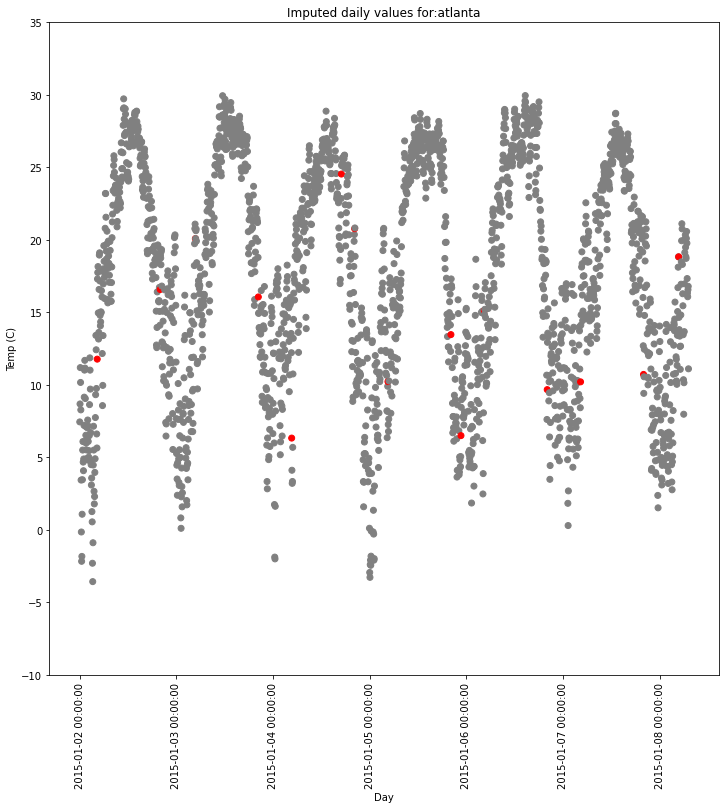

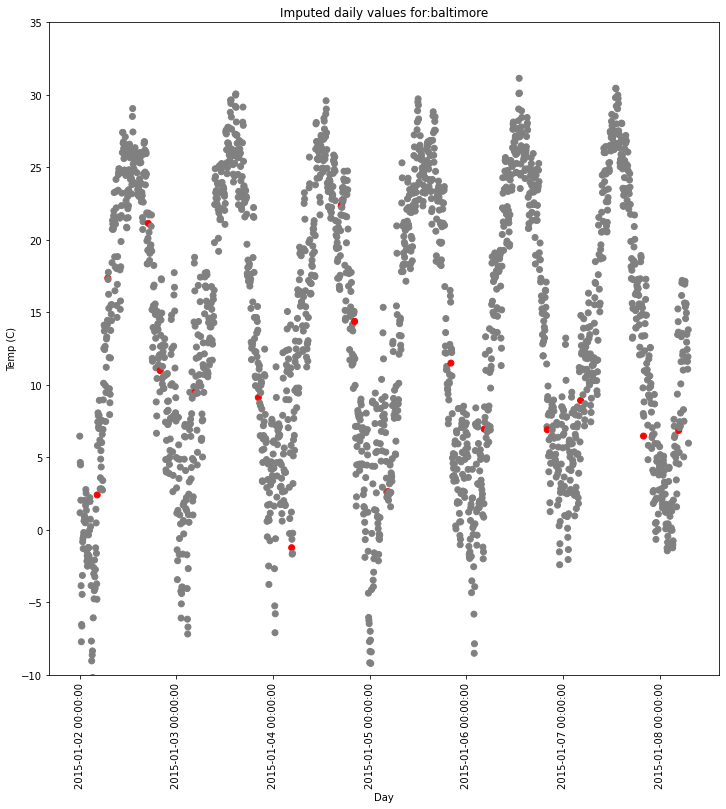

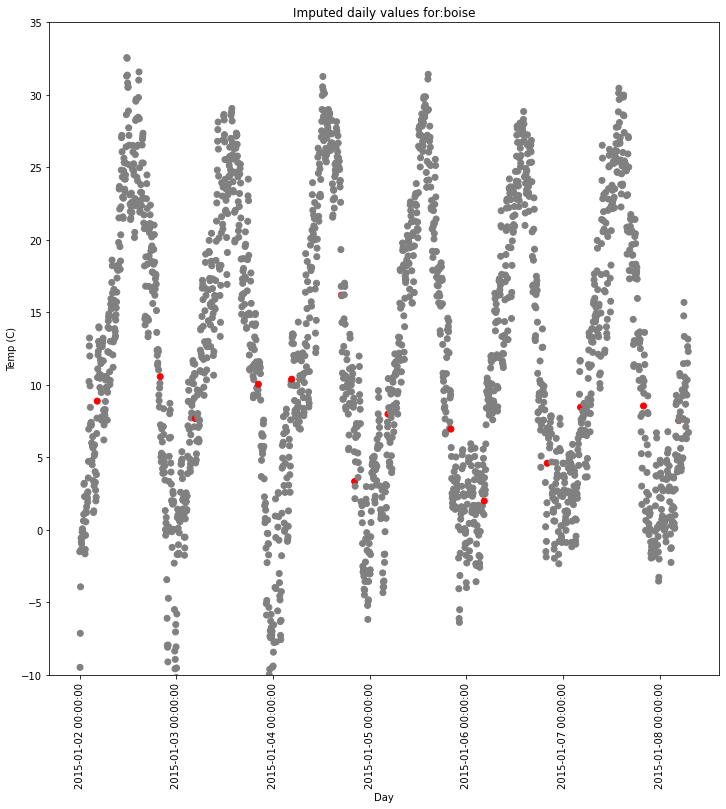

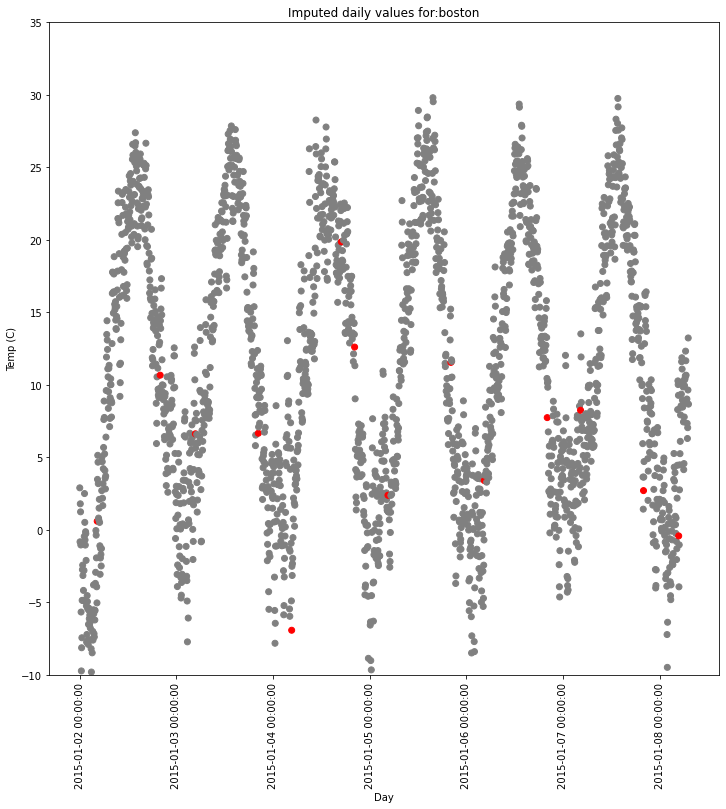

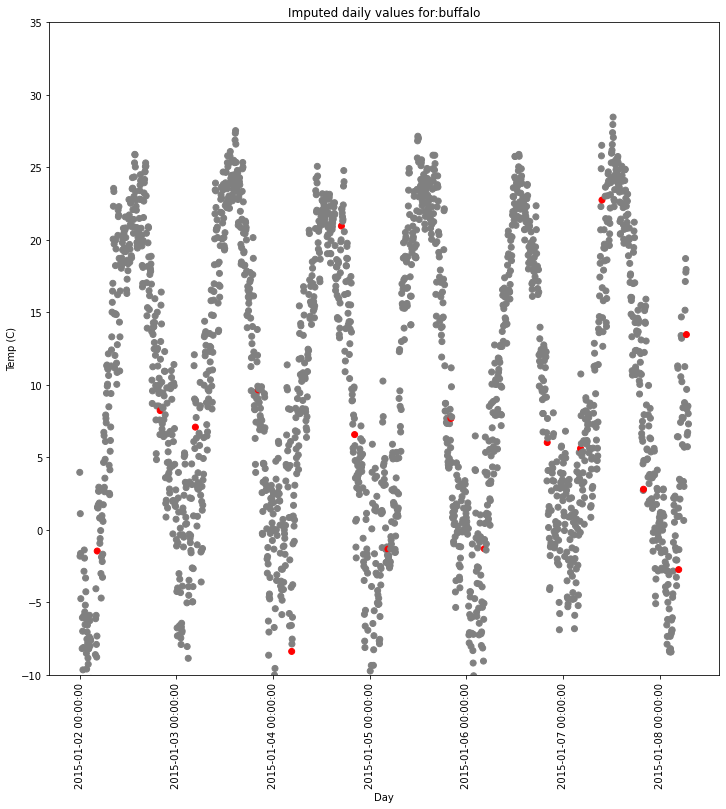

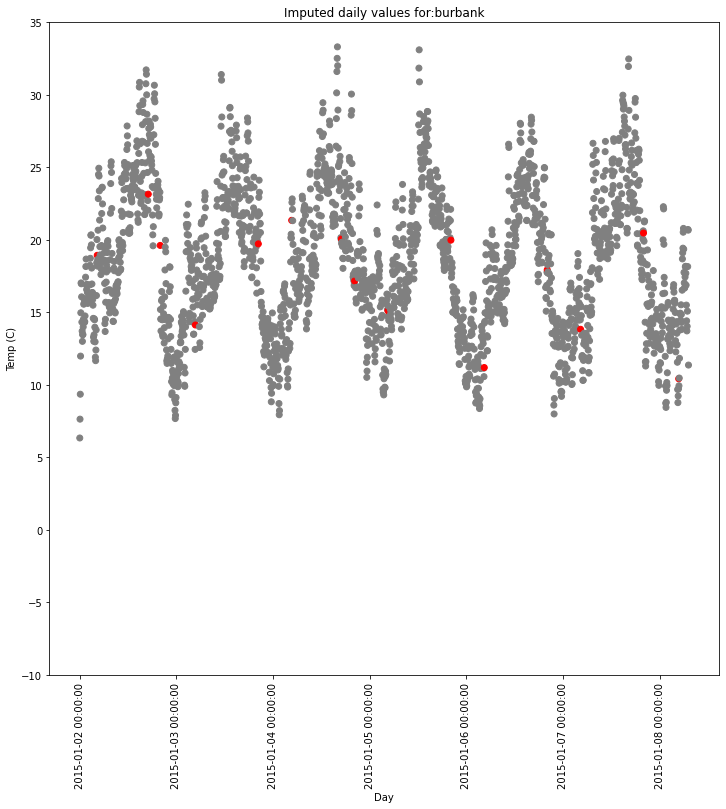

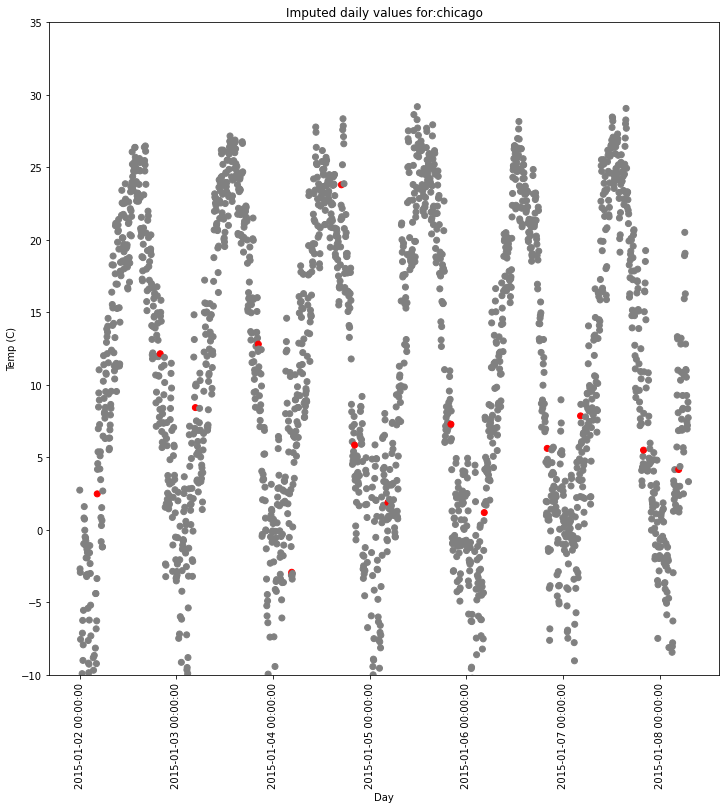

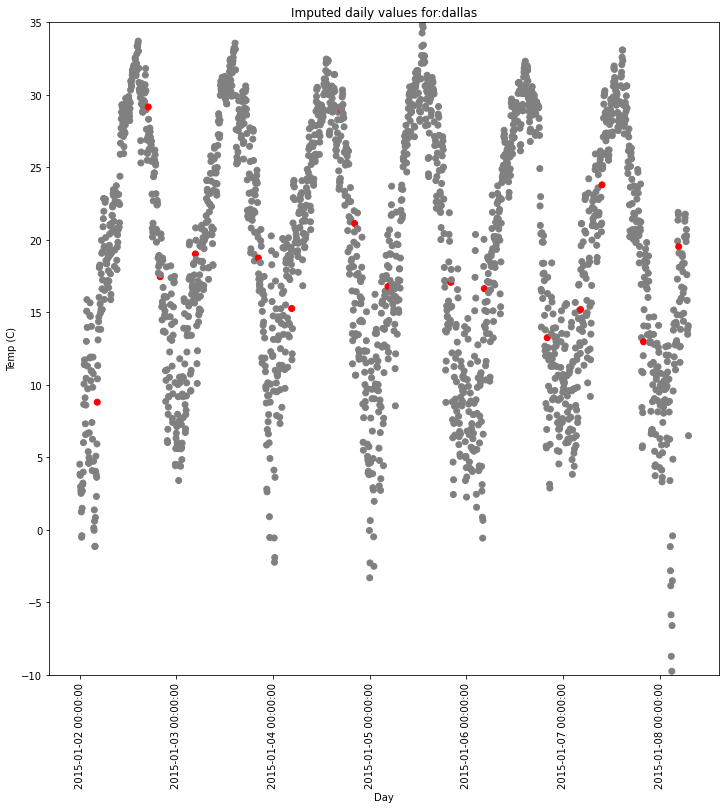

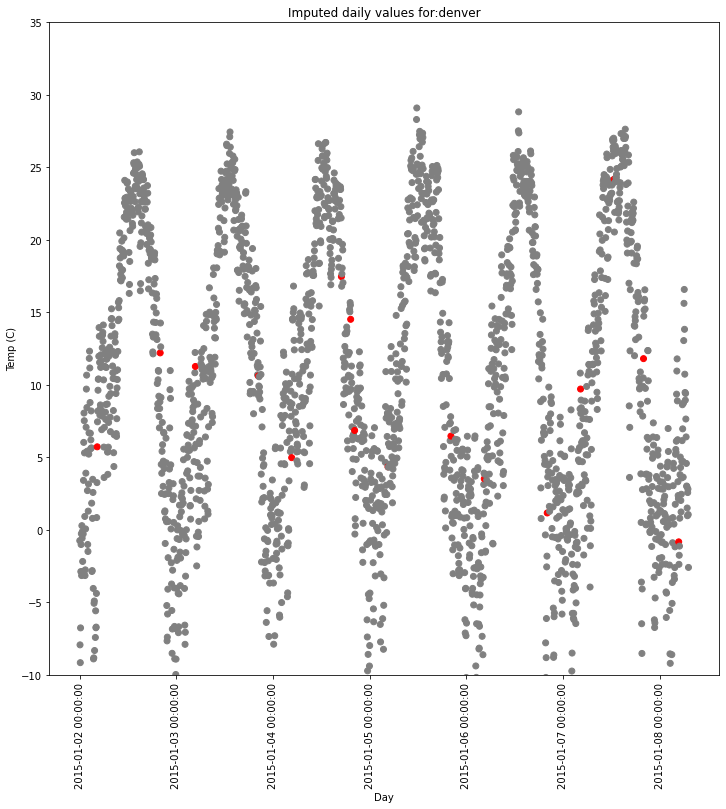

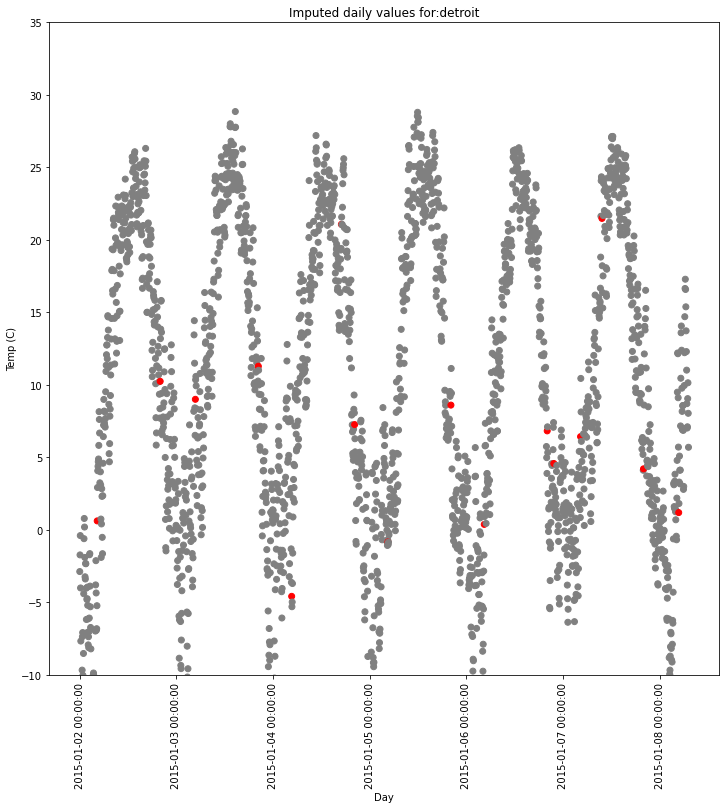

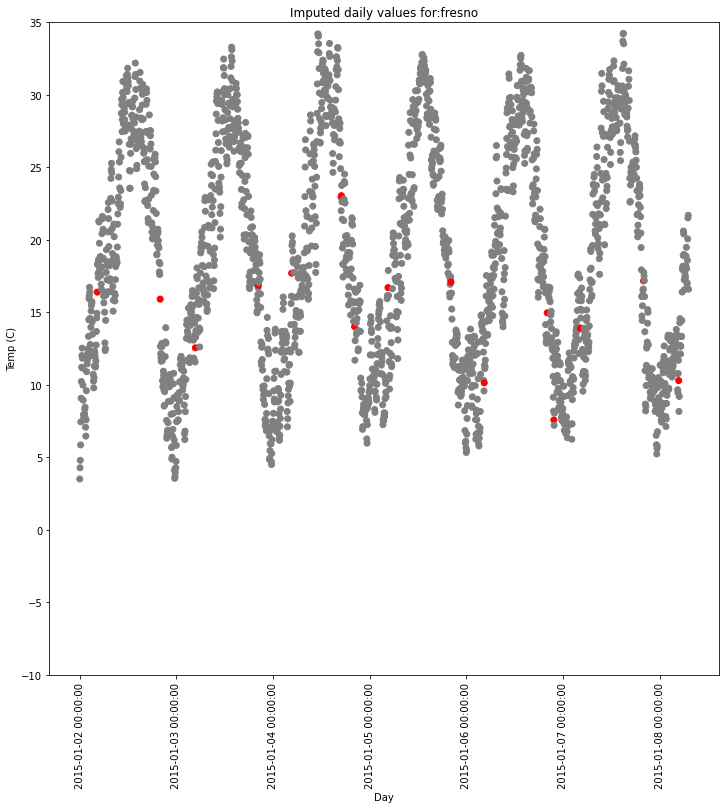

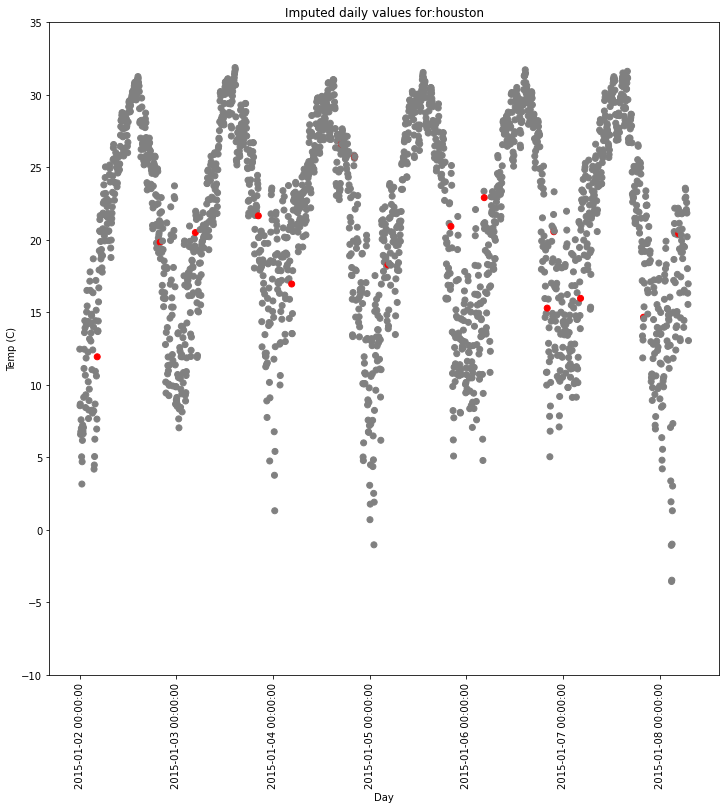

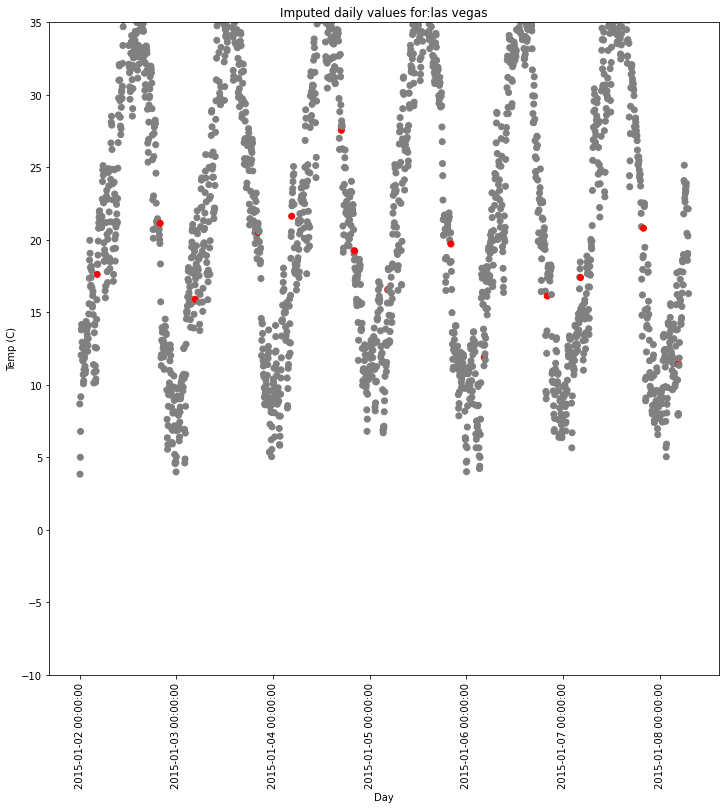

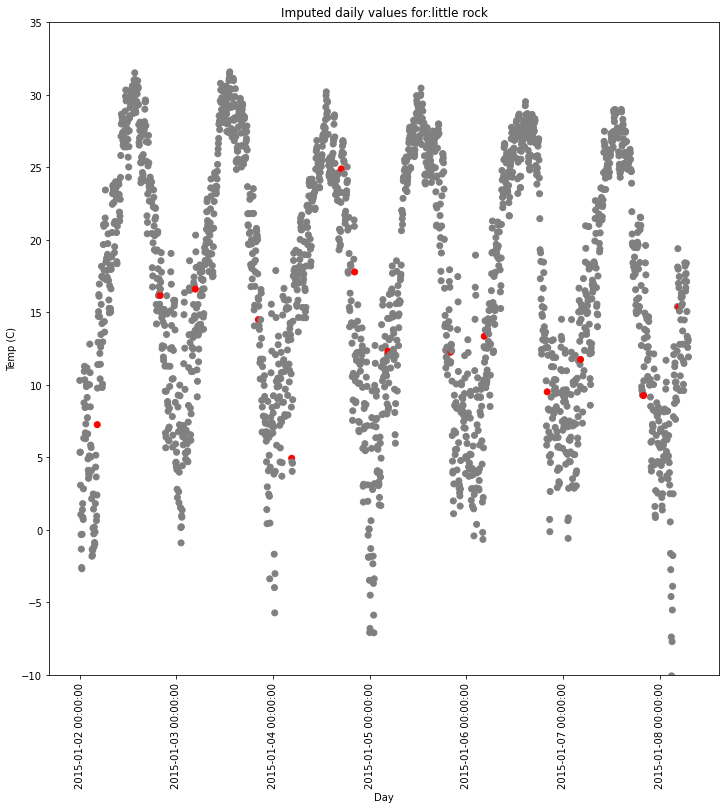

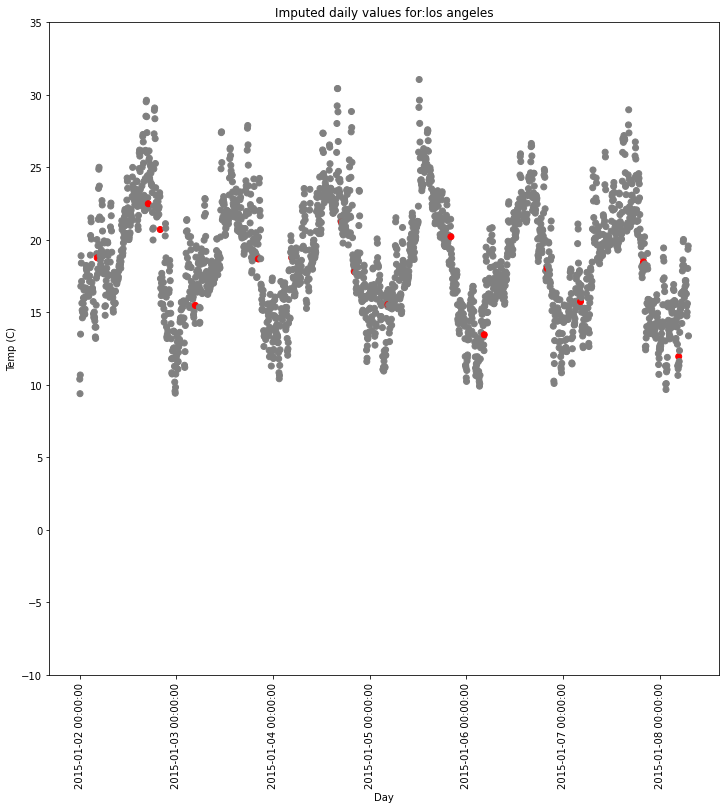

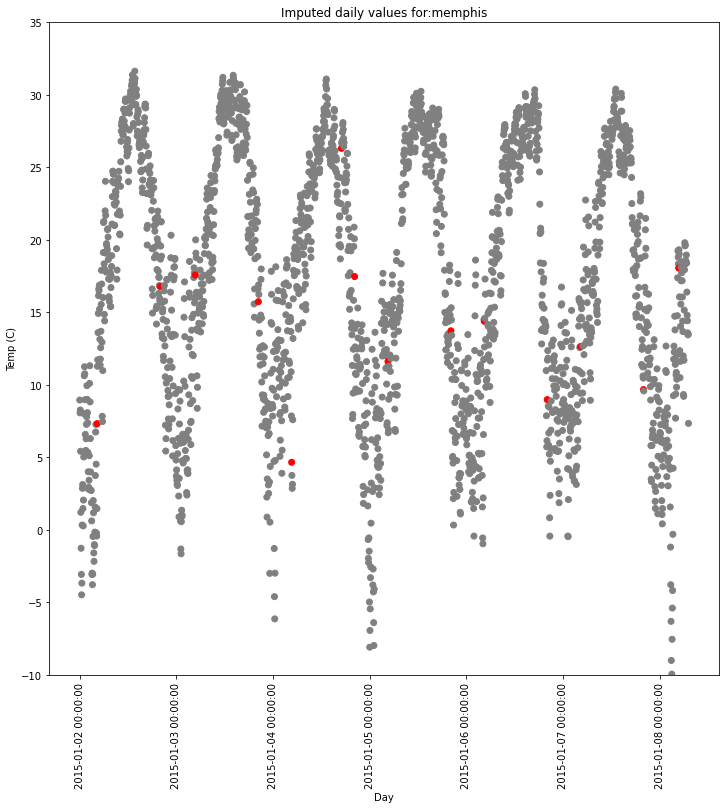

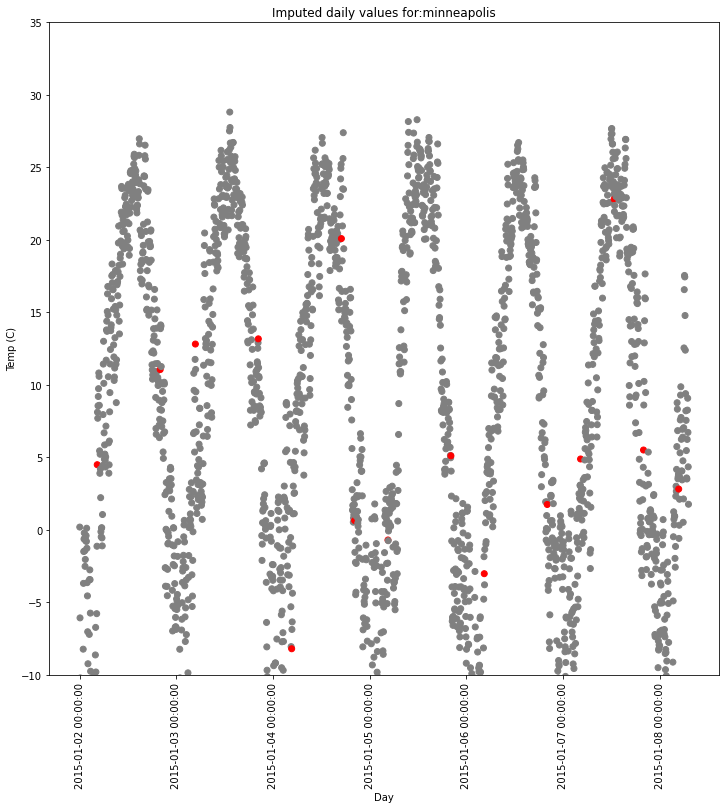

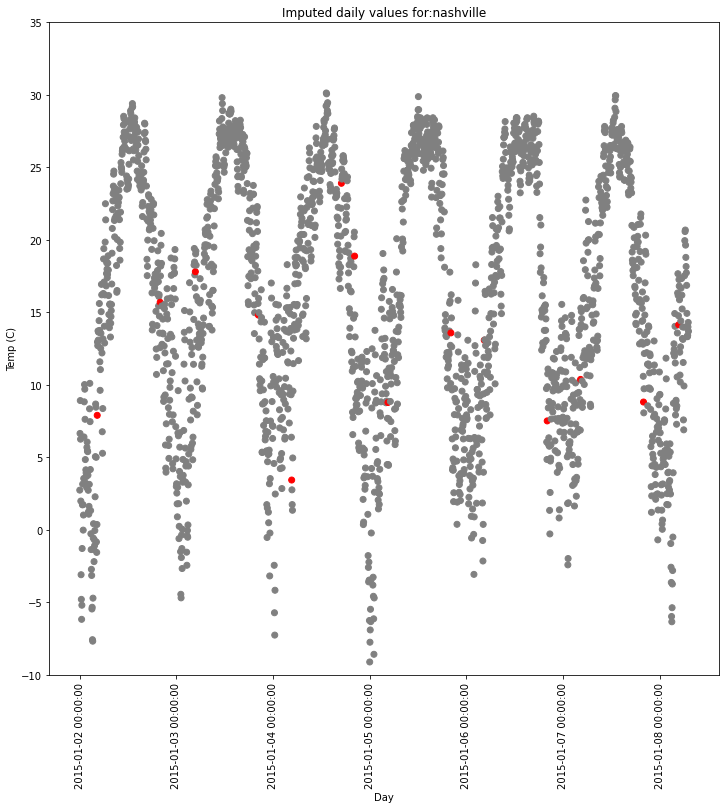

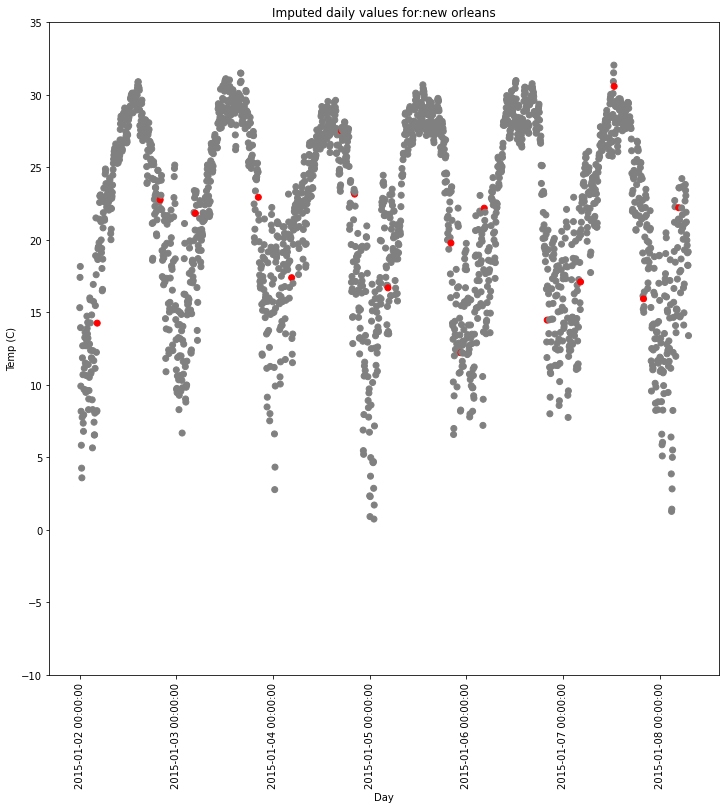

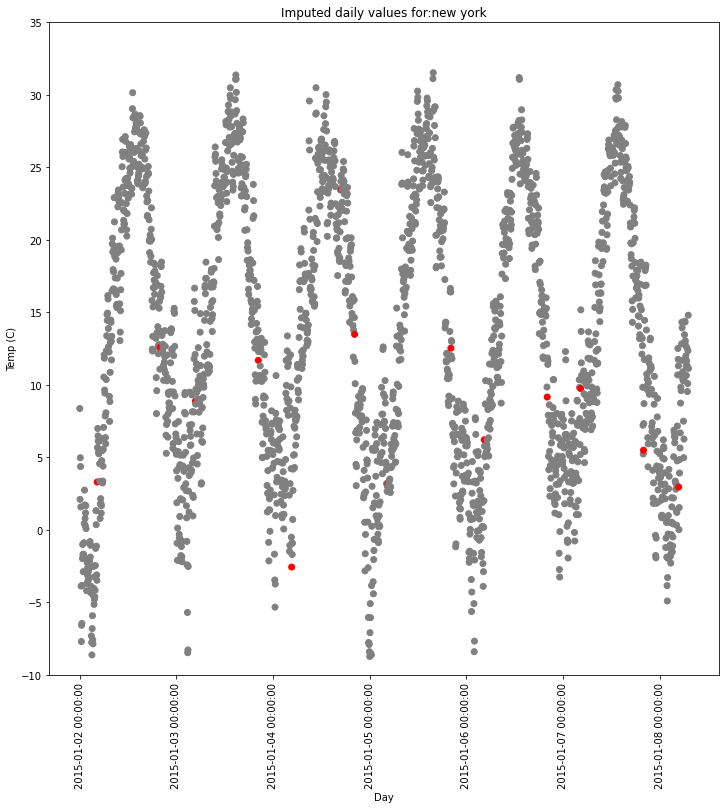

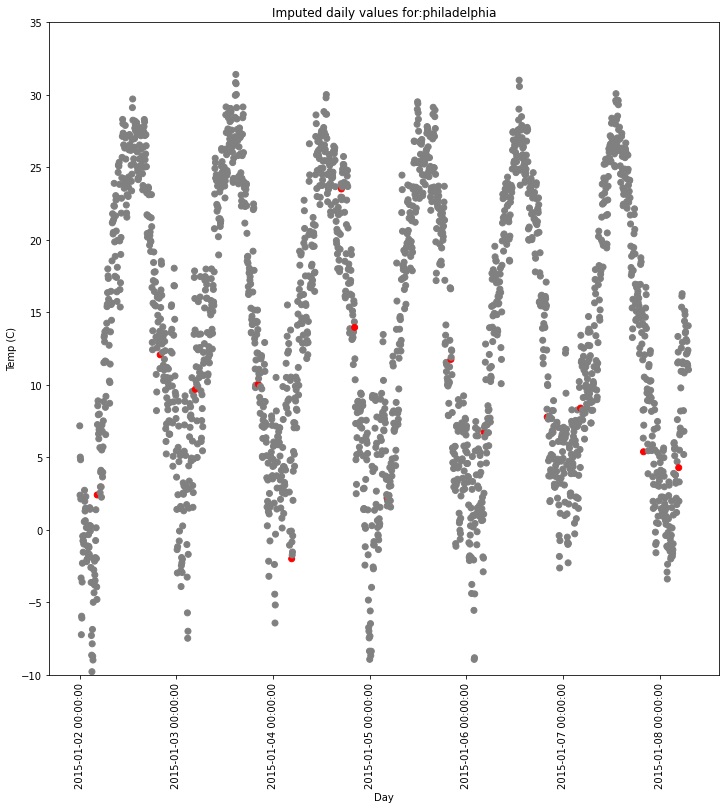

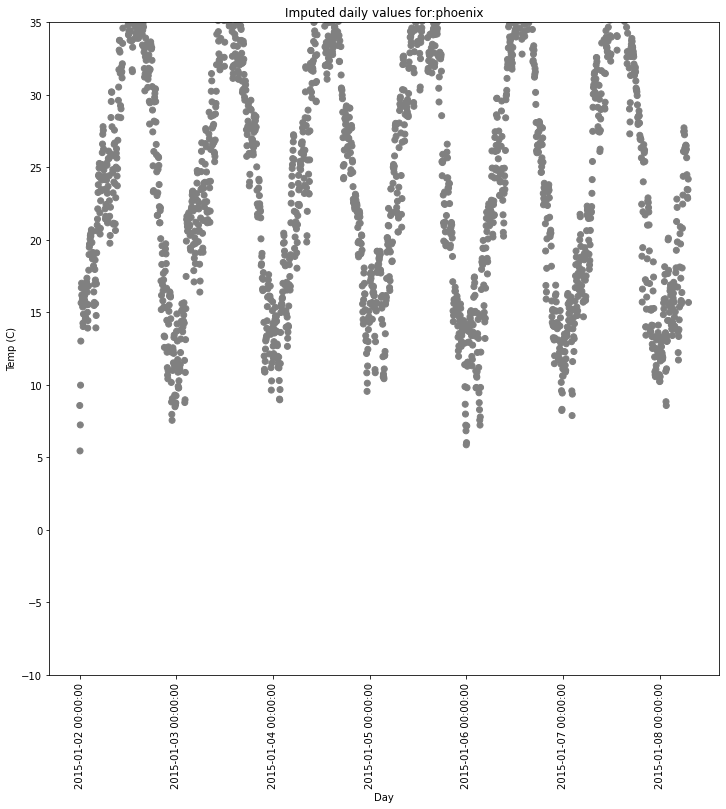

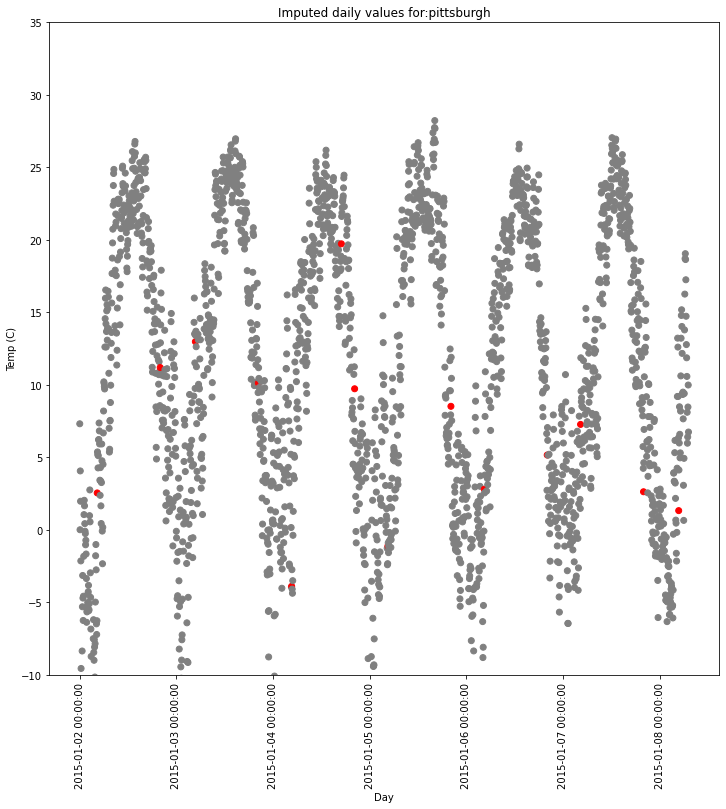

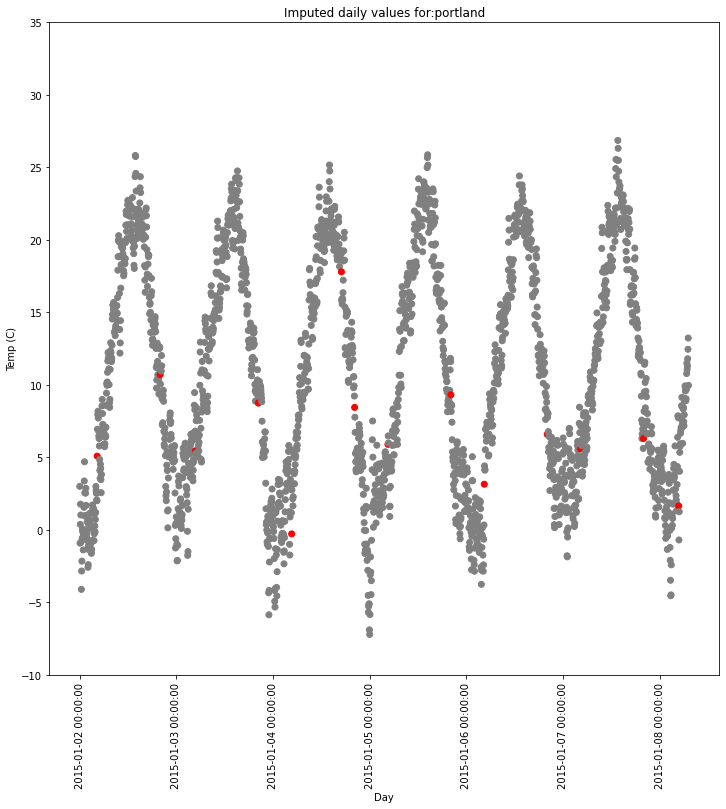

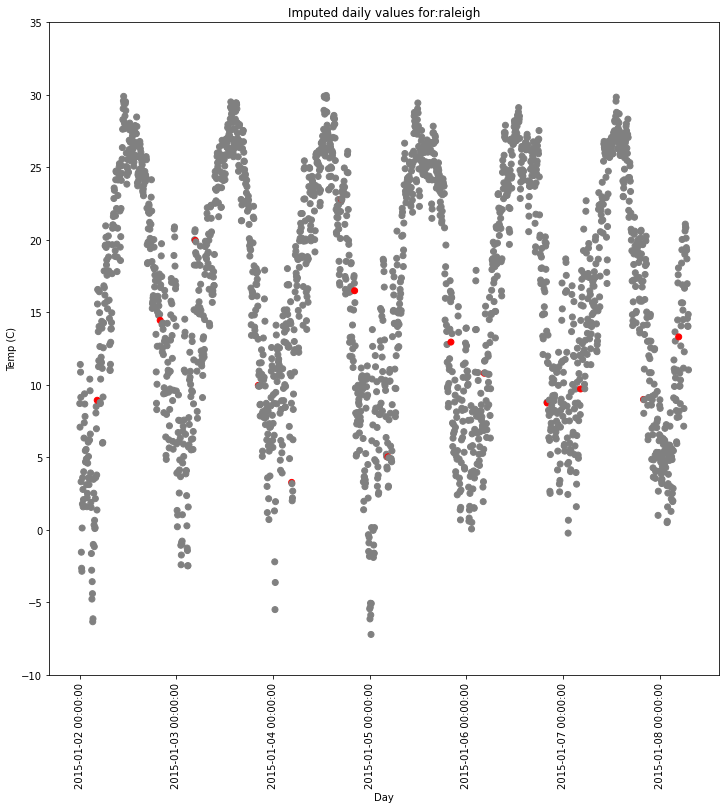

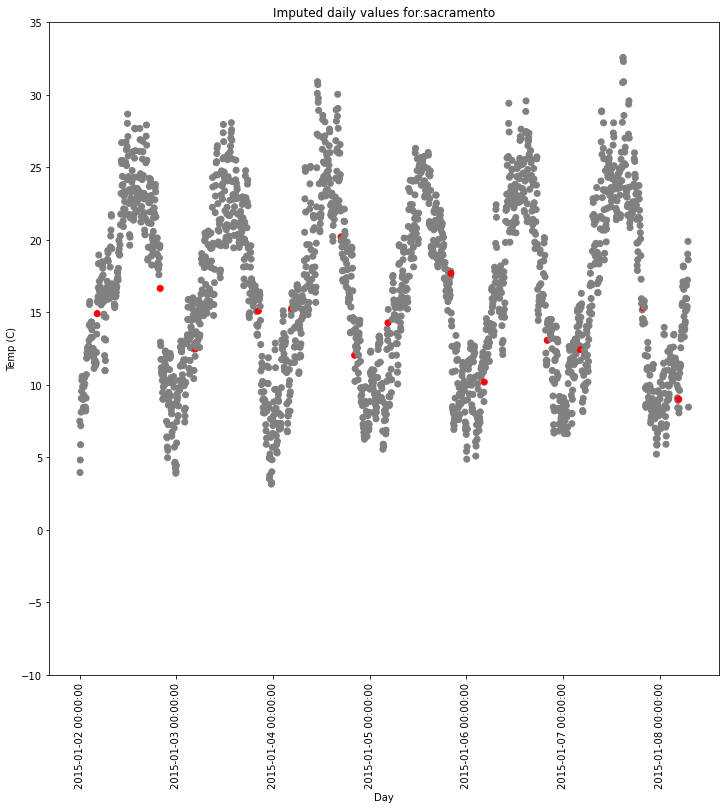

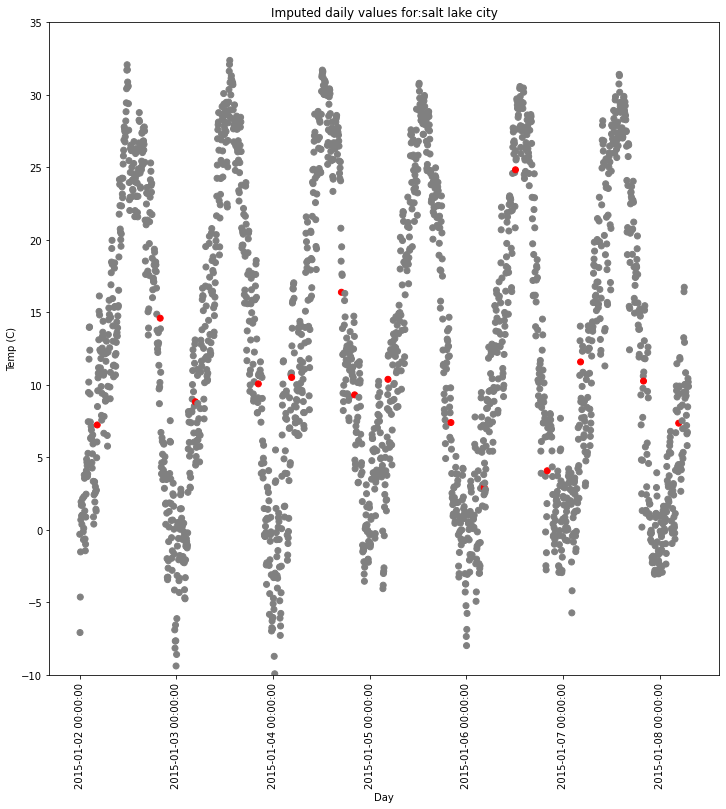

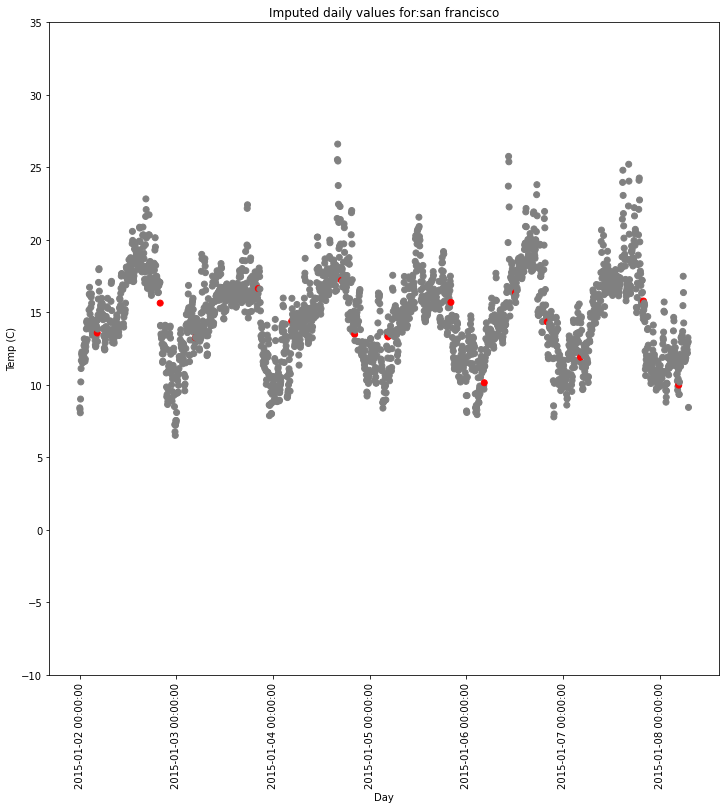

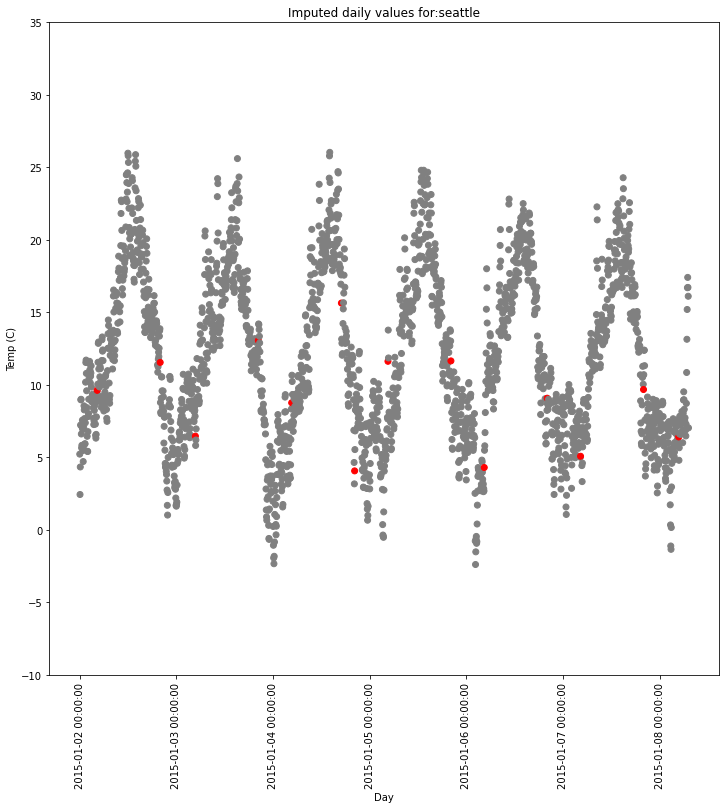

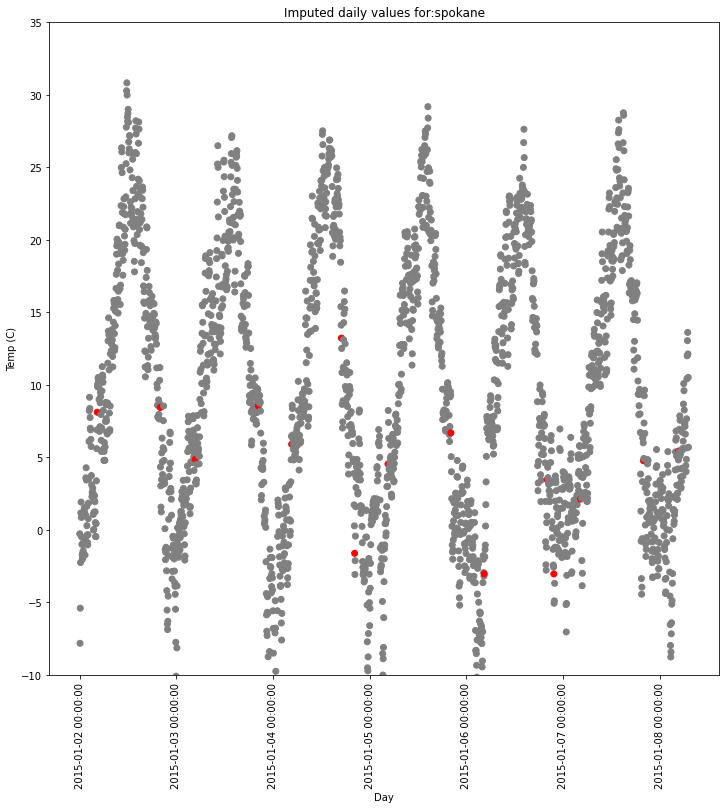

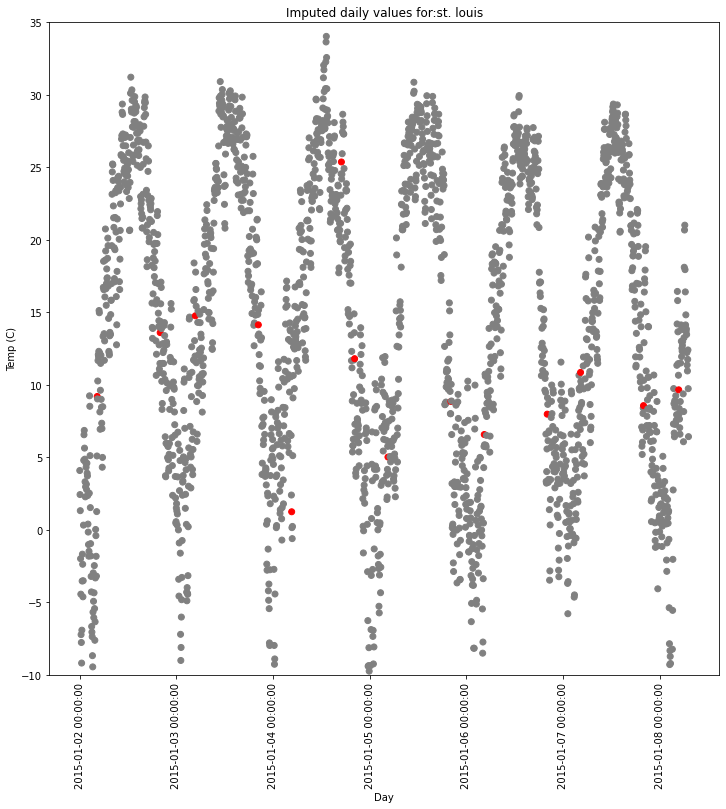

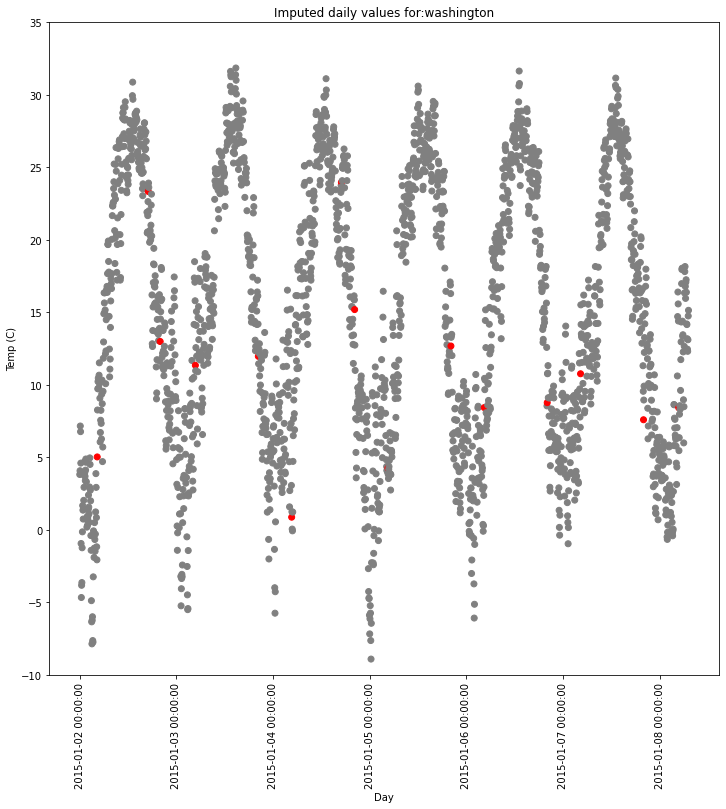

In [51]:
for x in df_missing_plot['name'].unique():
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(plot_dates, df_missing_plot[df_missing_plot['name'] ==x]['temp_mean_c'],c=df_missing_plot[df_missing_plot['name'] ==x]['missing']+20, cmap=cmap)
    # ax.plot(np.arange(1,13), df_month['temp_min_c'], color='black', linestyle='--')
    # ax.plot(np.arange(1,13), df_month['temp_max_c'], color='black', linestyle='--')
    # ax.plot(np.arange(1,13), df_month['temp_mean_c_prop'], color='grey')
    # ax.plot(np.arange(1,13), df_month['temp_min_c_prop'], color='grey', linestyle='--')
    # ax.plot(np.arange(1,13), df_month['temp_max_c_prop'], color='grey', linestyle='--')
    ax.set_xticklabels(pd.date_range(df_temp['date'].min(), df_temp['date'].max()), rotation=90)
    ax.set_xlabel('Day')
    ax.set_ylabel('Temp (C)')
    ax.set_title('Imputed daily values for:' + x)
    ax.set_ylim(-10,35)
    plt.show()